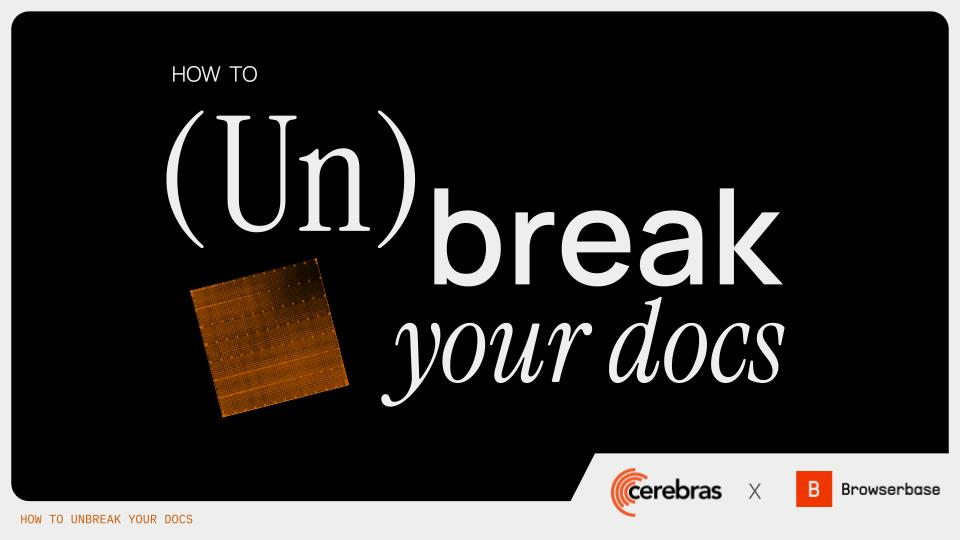

# **Build Your Own Docs Checker with Cerebras + Browserbase**
  
Verifying the validity of your docs is a key part of mantaining good documentation. However, manually auditing docs is tedious and error-prone.

This notebook builds an automated docs checker that crawls your documentation site with Browserbase and analyzes each page with Cerebras for quality issues.

This cookbook uses:

- Browserbase (Stagehand): AI-powered browser automation with built-in content extraction (Signup free here)

- Cerebras: Ultra-fast inference powering Stagehand's AI decisions (Get a FREE API key here)

- LangChain GitHub Loader: Dynamically verify code examples against actual source (Get a FREE API key here)


# Step 1: Environment Setup + API Keys

Install dependencies and configure Cerebras, Browserbase, and Langchain

In [ ]:
!pip install -q playwright browserbase stagehand langchain-community cerebras-cloud-sdk pandas pydantic GitPython
!python -m playwright install chromium

In [ ]:
import os
import asyncio
from datetime import datetime
from collections import deque, Counter
from urllib.parse import urlparse

import httpx
import pandas as pd

from pydantic import BaseModel, Field
from playwright.async_api import async_playwright
from IPython.display import display, clear_output, Markdown
from typing import Optional, List, Literal

Set your Cerebras and Browserbase credentials. You can also set these as environment variables.

In [ ]:
# CEREBRAS_API_KEY = os.getenv("CEREBRAS_API_KEY", "YOUR_CEREBRAS_API_KEY")
# BROWSERBASE_API_KEY = os.getenv("BROWSERBASE_API_KEY", "YOUR_BROWSERBASE_API_KEY")
# BROWSERBASE_PROJECT_ID = os.getenv("BROWSERBASE_PROJECT_ID", "YOUR_BROWSERBASE_PROJECT_ID")
CEREBRAS_API_KEY = os.getenv("CEREBRAS_API_KEY", "YOUR_CEREBRAS_API_KEY")
BROWSERBASE_API_KEY = os.getenv("BROWSERBASE_API_KEY", "YOUR_BROWSERBASE_API_KEY")
BROWSERBASE_PROJECT_ID = os.getenv("BROWSERBASE_PROJECT_ID", "YOUR_BROWSERBASE_PROJECT_ID")
GITHUB_ACCESS_TOKEN = os.getenv("GITHUB_ACCESS_TOKEN", "YOUR_GITHUB_TOKEN")

CEREBRAS_MODEL = "gpt-oss-120b"

print(f"✓ Configuration loaded")
print(f"  Model: {CEREBRAS_MODEL}")

✓ Configuration loaded
  Model: gpt-oss-120b


## Step 2: Define Data Models

First, create pydantic models to capture crawl results and detect issues.

Concretely, the checker will detect the following categories of issues:

- Unresolved references: links, anchors, or assets that fail to resolve.

- Invalid snippets: code or structured blocks that are syntactically invalid or contain obvious placeholders.

- Source-of-truth mismatches: claims in the docs that do not match an authoritative source (for example, a repository).

- Cross-page inconsistencies: factual contradictions across different documentation pages.

- Language errors: clear spelling or grammatical errors.

- Missing required elements: required context (such as authentication or installation steps) that is absent based on predefined rules.

In [ ]:
class Issue(BaseModel):
    category: str
    description: str
    page_url: str
    location: Optional[str] = None
    observed: Optional[str] = None
    expected: Optional[str] = None
    evidence: List[str] = Field(default_factory=list)

class LinkResult(BaseModel):
    url: str
    ok: bool
    status: Optional[int] = None
    error: Optional[str] = None

class PageResult(BaseModel):
    url: str
    issues: List[Issue] = Field(default_factory=list)
    links: List[LinkResult] = Field(default_factory=list)

print("✓ Data models defined")

✓ Data models defined


# Step 3: Crawl Documentation with Browserbase

Use a breadth-first search to discover pages, extract content, and detect broken links during the crawl itself.

In [ ]:
from browserbase import Browserbase

bb = Browserbase(api_key=BROWSERBASE_API_KEY)
session = bb.sessions.create(project_id=BROWSERBASE_PROJECT_ID)
BROWSERBASE_CDP_URL = session.connect_url


async def check_link(client: httpx.AsyncClient, url: str) -> LinkResult:
    """Return a LinkResult for whether this URL resolves (lightweight HTTP check)."""
    try:
        r = await client.head(url, follow_redirects=True, timeout=8)
        return LinkResult(url=url, ok=(r.status_code < 400), status=r.status_code, error=None)
    except Exception as e:
        return LinkResult(url=url, ok=False, status=None, error=str(e))


async def crawl(root_url: str, max_pages: int = 30, max_depth: int = 2) -> list[PageResult]:
    """
      1) Crawl pages (BFS)
      2) Collect links
      3) Check which links resolve (lightweight HTTP check)
      4) Emit PageResult with links + unresolved_reference issues
    """
    base_domain = urlparse(root_url).netloc

    visited: dict[str, PageResult] = {}
    queue = deque([(root_url, 0)])

    async with async_playwright() as p:
        browser = await p.chromium.connect_over_cdp(BROWSERBASE_CDP_URL)
        page = await browser.new_page()

        async with httpx.AsyncClient() as http:
            while queue and len(visited) < max_pages:
                url, depth = queue.popleft()
                url = url.split("#")[0]

                if url in visited or depth > max_depth:
                    continue

                clear_output(wait=True)
                print(f"Crawling [{len(visited)+1}/{max_pages}] (depth={depth}): {url[:80]}")

                result = PageResult(url=url)

                try:
                    await page.goto(url, timeout=15000, wait_until="domcontentloaded")

                    # Collect absolute links from the rendered page
                    links = await page.eval_on_selector_all(
                        "a[href]",
                        "els => els.map(e => e.href)"
                    )

                    # Check a capped number of links to keep this step cheap
                    for href in links[:30]:
                        if not href.startswith("http"):
                            continue

                        lr = await check_link(http, href)
                        result.links.append(lr)

                        if not lr.ok:
                            result.issues.append(
                                Issue(
                                    category="unresolved_reference",
                                    description=f"Link did not return a successful HTTP status (status={lr.status})",
                                    page_url=url,
                                    location=None,
                                    evidence=[href],
                                )
                            )

                        # Queue internal links for crawling
                        parsed = urlparse(href)
                        if parsed.netloc == base_domain:
                            next_url = href.split("#")[0]
                            if next_url not in visited:
                                queue.append((next_url, depth + 1))

                except Exception as e:
                    result.issues.append(
                        Issue(
                            category="unresolved_reference",
                            description="Page failed to load",
                            page_url=url,
                            location=None,
                            evidence=[str(e)],
                        )
                    )

                visited[url] = result

        await browser.close()

    clear_output(wait=True)
    print(f"✓ Crawled {len(visited)} pages")
    return list(visited.values())


# Step 5: AI Analysis with Cerebras

Next, use Stagehand (for agentic browser automation) powered by Cerebras (fast inference) to analyze content to identify deeper issues: outdated information, unclear writing, missing context, and grammar errors.

The analysis uses structured outputs for reliable JSON parsing.

In [ ]:
from cerebras.cloud.sdk import Cerebras

cerebras = Cerebras(api_key=CEREBRAS_API_KEY)
STAGEHAND_MODEL = f"cerebras/{CEREBRAS_MODEL}"

from IPython.display import clear_output
from stagehand import AsyncStagehand

ALLOWED_CATEGORIES = [
    "invalid_snippet",
    "source_of_truth_mismatch",
    "cross_page_inconsistency",
    "language_error",
    "missing_required_element",
]

ISSUES_SCHEMA = {
    "type": "array",
    "items": {
        "type": "object",
        "properties": {
            "category": {"type": "string", "enum": ALLOWED_CATEGORIES},
            "description": {"type": "string"},
            "location": {"type": ["string", "null"]},
            "observed": {"type": ["string", "null"]},
            "expected": {"type": ["string", "null"]},
            "evidence": {"type": "array", "items": {"type": "string"}},
        },
        "required": ["category", "description", "location", "observed", "expected", "evidence"],
        "additionalProperties": False,
    },
}


async def analyze_one_with_stagehand(pr: PageResult) -> PageResult:
    """
    Step 5: Use Stagehand (Cerebras-backed) to add objective issues.
    IMPORTANT: Do not report unresolved_reference here (Step 4 already did).
    """
    sh = AsyncStagehand(
        browserbase_api_key=BROWSERBASE_API_KEY,
        browserbase_project_id=BROWSERBASE_PROJECT_ID,
        model_api_key=CEREBRAS_API_KEY,
    )
    session = await sh.sessions.start(model_name=STAGEHAND_MODEL)

    try:
        await session.navigate(url=pr.url)

        instruction = f"""
You are reviewing a documentation page. Report ONLY objective issues.
URL: {pr.url}

Do NOT report broken links, broken anchors, or page load failures. Those are handled earlier.

Return issues only in these categories:
- invalid_snippet: invalid JSON/YAML, malformed code fences, obvious placeholders like TODO/<YOUR_KEY>
- source_of_truth_mismatch: contradicts an authoritative source (if provided)
- cross_page_inconsistency: contradicts other docs (if known)
- language_error: clear spelling/grammar errors (not style/tone)
- missing_required_element: missing required element based on explicit rules (e.g. API request shown but no auth mention)

For each issue include:
- location: best-effort section heading or a short locator string
- observed: the problematic text/snippet
- expected: what should be true instead (if applicable)
- evidence: short direct quotes/snippets
""".strip()

        resp = await session.extract(instruction=instruction, schema=ISSUES_SCHEMA)
        items = resp.data.result if resp and resp.data else []

        if isinstance(items, list):
            for item in items:
                if not isinstance(item, dict):
                    continue
                pr.issues.append(
                    Issue(
                        category=item["category"],
                        description=item["description"],
                        page_url=pr.url,
                        location=item.get("location"),
                        observed=item.get("observed"),
                        expected=item.get("expected"),
                        evidence=item.get("evidence", []),
                    )
                )
    finally:
        await session.end()

    return pr


async def analyze_all_optimized(page_results):
    """Single session for all pages = much faster"""
    print(f"Analyzing {len(page_results)} pages with single session...")

    sh = AsyncStagehand(
        browserbase_api_key=BROWSERBASE_API_KEY,
        browserbase_project_id=BROWSERBASE_PROJECT_ID,
        model_api_key=CEREBRAS_API_KEY)

    session = await sh.sessions.start(model_name=STAGEHAND_MODEL)
    print(f"Session: https://browserbase.com/sessions/{getattr(session, 'session_id', 'N/A')}")

    try:
        for i, pr in enumerate(page_results):
            print(f"[{i+1}/{len(page_results)}] {pr.url[:60]}...")
            try:
                await session.navigate(url=pr.url)
                resp = await session.extract(
                    instruction=f"Review {pr.url} for issues. Skip broken links.",
                    schema=ISSUES_SCHEMA)
                items = resp.data.result if resp and resp.data else []
                for item in (items if isinstance(items, list) else []):
                    if isinstance(item, dict):
                        pr.issues.append(Issue(
                            category=item["category"],
                            description=item["description"],
                            page_url=pr.url,
                            location=item.get("location"), observed=item.get("observed"), expected=item.get("expected"),
                            evidence=item.get("evidence", [])))
            except Exception as e:
                print(f"  Error: {e}")
    finally:
        await session.end()

    print(f"Done! {sum(len(p.issues) for p in page_results)} issues")
    return page_results

print("Ready! Use: page_results = await analyze_all_optimized(page_results)")

Ready! Use: page_results = await analyze_all_optimized(page_results)


# Step 6: Display Results

Finally, let's write three functions to view and export findings.

- `summarize`: Provides high-level statistics across all pages without listing individual issues

- `show_issues`: Displays all issues in a structured table, with optional filtering by severity (critical, high, medium, low)

- `export_issues`: Combines both views into a readable Markdown report with overall summaries and issue-level details

In [ ]:
def collect_issues(page_results: list[PageResult]) -> list[Issue]:
    """Flatten issues across all PageResults."""
    all_issues: list[Issue] = []
    for pr in page_results:
        all_issues.extend(pr.issues)
    return all_issues


def summarize(page_results: list[PageResult], root_url: str):
    """Display summary statistics (objective categories only)."""
    issues = collect_issues(page_results)

    category_counts = Counter(i.category for i in issues)
    unresolved = category_counts.get("unresolved_reference", 0)

    md = f"""### Summary for {root_url}

| Metric | Value |
|--------|-------|
| Pages crawled | {len(page_results)} |
| Total issues | {len(issues)} |
| Unresolved references | {unresolved} |

**By category:** {', '.join(f'{k}: {v}' for k, v in category_counts.most_common())}
"""
    display(Markdown(md))


def show_issues(page_results: list[PageResult], category_filter: str = None, limit: int = 200):
    """
    Display issues as a table, optionally filtered by category.
    """
    issues = collect_issues(page_results)
    filtered = [i for i in issues if category_filter is None or i.category == category_filter]

    if not filtered:
        print(f"No {category_filter + ' ' if category_filter else ''}issues found.")
        return

    # Keep display compact + useful
    rows = []
    for i in filtered[:limit]:
        page_name = i.page_url.split("/")[-1] or "index"
        rows.append({
            "Category": i.category,
            "Page": page_name,
            "URL": i.page_url,
            "Location": i.location or "",
            "Description": (i.description[:90] + "…") if len(i.description) > 90 else i.description,
            "Observed": (i.observed[:70] + "…") if i.observed and len(i.observed) > 70 else (i.observed or ""),
            "Expected": (i.expected[:70] + "…") if i.expected and len(i.expected) > 70 else (i.expected or ""),
            "Evidence": (i.evidence[0][:70] + "…") if i.evidence else "",
        })

    df = pd.DataFrame(rows)
    display(df)


def export_markdown(page_results: list[PageResult], root_url: str) -> str:
    """Generate a Markdown report (objective + evidence-based)."""
    issues = collect_issues(page_results)
    category_counts = Counter(i.category for i in issues)

    report = f"""# Documentation Analysis Report

**Site:** {root_url}
**Date:** {datetime.now().strftime("%Y-%m-%d %H:%M")}
**Pages:** {len(page_results)} | **Issues:** {len(issues)}

## Summary

| Category | Count |
|----------|-------|
"""
    for cat, cnt in category_counts.most_common():
        report += f"| {cat} | {cnt} |\n"

    report += "\n## Issues\n\n"

    # Group by category for readability
    for cat, cnt in category_counts.most_common():
        report += f"### {cat} ({cnt})\n\n"
        cat_issues = [i for i in issues if i.category == cat]

        for i in cat_issues:
            page_name = i.page_url.split("/")[-1] or "index"
            report += f"- **[{page_name}]** {i.description}\n"
            if i.location:
                report += f"  - Location: `{i.location}`\n"
            if i.observed:
                report += f"  - Observed: `{i.observed}`\n"
            if i.expected:
                report += f"  - Expected: `{i.expected}`\n"
            if i.evidence:
                # keep evidence readable; don’t dump giant blobs
                ev = i.evidence[:2]
                report += f"  - Evidence: {', '.join(f'`{e}`' for e in ev)}\n"
        report += "\n"

    return report


In [ ]:
#@title Report Display
from IPython.display import HTML, display

# Cerebras Brand Colors
CEREBRAS_DARK = "#1a1a2e"
CEREBRAS_ORANGE = "#f97316"
CEREBRAS_GRAY = "#2d2d44"
CEREBRAS_TEXT = "#e5e5e5"

def display_styled_report(page_results: list, root_url: str):
    """Generate a beautiful Cerebras-branded HTML report."""
    issues = collect_issues(page_results)
    category_counts = Counter(i.category for i in issues)

    # Build summary rows
    summary_rows = "".join([
        f'<tr><td style="padding:8px;border-bottom:1px solid {CEREBRAS_GRAY};">{cat}</td>'
        f'<td style="padding:8px;border-bottom:1px solid {CEREBRAS_GRAY};text-align:right;">{cnt}</td></tr>'
        for cat, cnt in category_counts.most_common()
    ])

    # Build issues HTML
    issues_html = ""
    for cat, cnt in category_counts.most_common():
        cat_issues = [i for i in issues if i.category == cat]
        issues_html += f'''
        <div style="margin-top:20px;">
            <h3 style="color:{CEREBRAS_ORANGE};border-left:4px solid {CEREBRAS_ORANGE};padding-left:10px;">
                {cat} ({cnt})
            </h3>
        '''
        for i in cat_issues[:10]:  # Limit to 10 per category
            page_name = i.page_url.split("/")[-1] or "index"
            issues_html += f'''
            <div style="background:{CEREBRAS_GRAY};padding:12px;margin:8px 0;border-radius:6px;">
                <strong style="color:{CEREBRAS_ORANGE};">[{page_name}]</strong>
                <span style="color:{CEREBRAS_TEXT};">{i.description[:100]}...</span>
            </div>
            '''
        issues_html += "</div>"

    html = f'''
    <div style="background:{CEREBRAS_DARK};color:{CEREBRAS_TEXT};padding:30px;border-radius:12px;font-family:system-ui;">
        <h1 style="color:{CEREBRAS_ORANGE};margin-bottom:5px;">Documentation Analysis Report</h1>
        <p style="color:#888;margin-top:0;">Site: <a href="{root_url}" style="color:{CEREBRAS_ORANGE};">{root_url}</a></p>
        <p style="color:#888;">Pages: {len(page_results)} | Issues: {len(issues)}</p>

        <h2 style="color:{CEREBRAS_TEXT};border-bottom:2px solid {CEREBRAS_ORANGE};padding-bottom:10px;">Summary</h2>
        <table style="width:100%;border-collapse:collapse;margin:15px 0;">
            <tr style="background:{CEREBRAS_GRAY};">
                <th style="padding:10px;text-align:left;">Category</th>
                <th style="padding:10px;text-align:right;">Count</th>
            </tr>
            {summary_rows}
        </table>

        <h2 style="color:{CEREBRAS_TEXT};border-bottom:2px solid {CEREBRAS_ORANGE};padding-bottom:10px;margin-top:30px;">Issues</h2>
        {issues_html}

        <div style="margin-top:30px;padding-top:20px;border-top:1px solid {CEREBRAS_GRAY};text-align:center;color:#666;">
            Powered by Cerebras + Browserbase
        </div>
    </div>
    '''
    display(HTML(html))

print("Styled display ready! Use: display_styled_report(page_results, DOCS_URL)")

# Step 7: Run the Analysis

As a last step, configure your target docs site and run the full pipeline.

In [1]:
# Configure your target
DOCS_URL = "https://docs.browser-use.com/"
MAX_PAGES = 30
MAX_DEPTH = 2

# Crawl
page_results = await crawl(
    DOCS_URL,
    max_pages=MAX_PAGES,
    max_depth=MAX_DEPTH,
)

NameError: name 'crawl' is not defined

In [ ]:
# Analyze
page_results = await analyze_all_optimized(page_results)

# Show results
summarize(page_results, DOCS_URL)
show_issues(page_results)

Analyzing 11 pages with single session...
Session: https://browserbase.com/sessions/N/A
[1/11] https://docs.browser-use.com/...
[2/11] https://docs.browser-use.com/introduction...
[3/11] https://docs.browser-use.com/quickstart...
[4/11] https://docs.browser-use.com/quickstart_llm...
[5/11] https://docs.browser-use.com/supported-models...
[6/11] https://docs.browser-use.com/production...
[7/11] https://docs.browser-use.com/development/get-help...
[8/11] https://docs.browser-use.com/customize/browser/basics...
[9/11] https://docs.browser-use.com/customize/sandbox/quickstart...
[10/11] https://docs.browser-use.com/customize/agent/basics...
[11/11] https://docs.browser-use.com/development/monitoring/costs...
Done! 76 issues


### Summary for https://docs.browser-use.com/

| Metric | Value |
|--------|-------|
| Pages crawled | 11 |
| Total issues | 76 |
| Unresolved references | 17 |

**By category:** Accessibility: 42, unresolved_reference: 17, Usability: 5, Content: 4, Navigation: 2, Structure: 1, Deprecated Environment Variable: 1, Action Schema Format Issue: 1, Form Accessibility: 1, Branding / Attribution: 1, Code: 1


,Category,Page,URL,Location,Description,Observed,Expected,Evidence
0,unresolved_reference,index,https://docs.browser-use.com/,,Link did not return a successful HTTP status (...,,,https://x.com/browser_use…
1,Accessibility,index,https://docs.browser-use.com/,image: dark logo; image: Browser Use Logo; ima...,"Image elements are missing alternative text, w...",Images have no alt attribute or descriptive text.,All images should include a meaningful alt att...,2-171 image: dark logo…
2,Accessibility,index,https://docs.browser-use.com/,button: Toggle dark mode; button: Yes; button: No,Buttons that rely solely on an image for their...,Buttons contain only an image element and no v...,Each button should provide a clear accessible ...,2-211 button: Toggle dark mode (contains only ...
3,Usability,index,https://docs.browser-use.com/,link: x in the footer contentinfo section,"Link labeled with a single character ""x"" provi...","Link text is just ""x"", which is ambiguous.",Link should have descriptive text indicating i...,2-537 link: x…
4,Navigation,index,https://docs.browser-use.com/,listitem containing link: Get Help under Devel...,"The ""Get Help"" link is placed inside a list it...",Link appears as a plain list item without a pr...,Group support links under a clear heading such...,2-409 link: Get Help…
...,...,...,...,...,...,...,...,...
71,Accessibility,costs,https://docs.browser-use.com/development/monit...,"Heading ""Navigate to header Cost Tracking"" – l...",Link with no visible accessible name,Link contains only a zero‑width space characte...,Link should have a readable label or aria‑labe...,StaticText: ​…
72,Content,costs,https://docs.browser-use.com/development/monit...,"Heading element with text ""Navigate to header ...",Redundant and confusing heading text,Heading combines navigation instruction with t...,"Heading should be concise and focused, e.g., ""...",StaticText: Cost Tracking…
73,Accessibility,costs,https://docs.browser-use.com/development/monit...,Buttons that contain only an image child,"Buttons ""More actions"" and ""Ask AI"" lack acces...",Each button includes only an image element wit...,Buttons should provide an accessible name via ...,button: More actions…
74,Code,costs,https://docs.browser-use.com/development/monit...,"Code block under ""Copy the contents from the c...","Import statement split across multiple lines, ...","First three lines are separate static texts: ""...","A single valid import line, e.g., ""from browse...",StaticText: from…


In [ ]:
# Export report
report_md = export_markdown(page_results, DOCS_URL)
display(Markdown(report_md))

# Documentation Analysis Report

**Site:** https://docs.browser-use.com/
**Date:** 2026-02-05 13:09
**Pages:** 11 | **Issues:** 76

## Summary

| Category | Count |
|----------|-------|
| Accessibility | 42 |
| unresolved_reference | 17 |
| Usability | 5 |
| Content | 4 |
| Navigation | 2 |
| Structure | 1 |
| Deprecated Environment Variable | 1 |
| Action Schema Format Issue | 1 |
| Form Accessibility | 1 |
| Branding / Attribution | 1 |
| Code | 1 |

## Issues

### Accessibility (42)

- **[index]** Image elements are missing alternative text, which prevents screen readers from conveying their purpose.
  - Location: `image: dark logo; image: Browser Use Logo; image (various icons within buttons and sections)`
  - Observed: `Images have no alt attribute or descriptive text.`
  - Expected: `All images should include a meaningful alt attribute or be marked aria-hidden="true" if decorative.`
  - Evidence: `2-171 image: dark logo`, `2-463 image: Browser Use Logo`
- **[index]** Buttons that rely solely on an image for their label lack an accessible name, making them unreadable to assistive technologies.
  - Location: `button: Toggle dark mode; button: Yes; button: No`
  - Observed: `Buttons contain only an image element and no visible text or aria-label.`
  - Expected: `Each button should provide a clear accessible name via visible text, aria-label, or aria-labelledby.`
  - Evidence: `2-211 button: Toggle dark mode (contains only image 2-226)`, `2-498 button: Yes (contains only image 2-499)`
- **[introduction]** Image elements are missing alternative text (alt attribute).
  - Location: `[2-1266] image: dark logo; [2-1271] image; [2-1278] image; [2-1316] image; [2-1390] image; [2-1396] image; [2-1402] image; [2-1408] image; [2-1414] image; [2-1420] image; [2-1426] image; [2-1432] image; [2-1444] image; [2-1450] image; [2-1462] image; [2-1468] image; [2-1474] image; [2-1501] image; [2-1506] image; [2-1561] image; [2-1565] image; [2-1589] image; [2-1607] image`
  - Observed: `Images are present without any alt text, which prevents screen readers from conveying their purpose.`
  - Expected: `All image elements should include a meaningful alt attribute describing the image content or purpose.`
  - Evidence: `image element at [2-1266] has no alt text.`, `image element at [2-1271] has no alt text.`
- **[introduction]** Buttons "Yes" and "No" contain only images and lack accessible text or aria-labels.
  - Location: `[2-1560] button: Yes; [2-1564] button: No`
  - Observed: `Both buttons rely solely on an image for their label, providing no readable text for assistive technologies.`
  - Expected: `Buttons should contain visible text or an aria-label attribute that clearly describes their action (e.g., aria-label="Yes" and aria-label="No").`
  - Evidence: `button at [2-1560] contains only an image ([2-1561]) and no text.`, `button at [2-1564] contains only an image ([2-1565]) and no text.`
- **[introduction]** The textbox for asking a question lacks an associated label.
  - Location: `[2-1582] textbox: Ask a question...`
  - Observed: `The textbox has placeholder text but no <label> element or aria-label, which may be insufficient for screen readers.`
  - Expected: `Provide a <label> element linked via the 'for' attribute or add an aria-label="Ask a question" to the textbox.`
  - Evidence: `textbox at [2-1582] shows placeholder "Ask a question..." without a label element.`
- **[introduction]** Links with non‑descriptive text such as "x", "github", "linkedin", and "Powered by" do not convey clear purpose.
  - Location: `[2-1594] link: x; [2-1597] link: github; [2-1600] link: linkedin; [2-1605] link: Powered by`
  - Observed: `Link text is vague or generic, which can be ambiguous for users and screen readers.`
  - Expected: `Use descriptive link text (e.g., "Close dialog", "GitHub repository", "LinkedIn profile", "Powered by Browser Use") or provide aria-labels that clarify the destination.`
  - Evidence: `link at [2-1594] displays "x".`, `link at [2-1597] displays "github".`
- **[introduction]** Toggle buttons for sections (e.g., Agent, Code Agent, Browser, etc.) lack ARIA attributes indicating expanded/collapsed state.
  - Location: `[2-1387] button: Toggle Agent section; [2-1393] button: Toggle Code Agent section; [2-1399] button: Toggle Browser section; [2-1405] button: Toggle Tools section; [2-1411] button: Toggle Skills section; [2-1417] button: Toggle Actor section; [2-1423] button: Toggle Integration section; [2-1429] button: Toggle Sandbox section; [2-1441] button: Toggle Templates section; [2-1447] button: Toggle Apps section; [2-1459] button: Toggle Contribution section; [2-1465] button: Toggle Advanced section; [2-1471] button: Toggle Monitoring section`
  - Observed: `These buttons control collapsible content but do not have aria-expanded or aria-controls attributes, making it unclear to assistive technologies whether the content is visible.`
  - Expected: `Add aria-expanded="false" (or "true" when open) and aria-controls="<id-of-panel>" to each toggle button.`
  - Evidence: `button at [2-1387] labeled "Toggle Agent section" has no ARIA state.`, `button at [2-1393] labeled "Toggle Code Agent section" has no ARIA state.`
- **[quickstart]** Image element missing alt text
  - Location: `2-2289`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image: dark logo (ID 2-2289)`
- **[quickstart]** Image element missing alt text
  - Location: `2-2294`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image (ID 2-2294) – search icon`
- **[quickstart]** Image element missing alt text
  - Location: `2-2300`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image (ID 2-2300) – Ask AI icon`
- **[quickstart]** Image element missing alt text
  - Location: `2-2319`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image (ID 2-2319) – Browser Use Cloud logo`
- **[quickstart]** Image element missing alt text
  - Location: `2-2553`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image: Note (ID 2-2553)`
- **[quickstart]** Image element missing alt text
  - Location: `2-2574`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image (ID 2-2574) – copy button icon`
- **[quickstart]** Image element missing alt text
  - Location: `2-2605`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image (ID 2-2605) – copy button icon`
- **[quickstart]** Image element missing alt text
  - Location: `2-2632`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image (ID 2-2632) – copy button icon`
- **[quickstart]** Image element missing alt text
  - Location: `2-2679`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image (ID 2-2679) – copy button icon`
- **[quickstart]** Image element missing alt text
  - Location: `2-2699`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image: Info (ID 2-2699)`
- **[quickstart]** Image element missing alt text
  - Location: `2-2719`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image (ID 2-2719) – copy button icon in Browser Use tabpanel`
- **[quickstart]** Image element missing alt text
  - Location: `2-2725`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image (ID 2-2725) – ask AI button icon in Browser Use tabpanel`
- **[quickstart]** Image element missing alt text
  - Location: `2-2850`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image: Note (ID 2-2850)`
- **[quickstart]** Image element missing alt text
  - Location: `2-2951`
  - Observed: `image element without alt attribute`
  - Expected: `image should have alt attribute describing the image`
  - Evidence: `image (ID 2-2951) – ask AI button icon in production code block`
- **[quickstart]** Link element has no accessible name
  - Location: `2-2562`
  - Observed: `link contains only zero‑width space and an image, no visible text`
  - Expected: `link should have descriptive text for screen readers`
  - Evidence: `link: Navigate to header (ID 2-2562) – contains StaticText: ​ and an image`
- **[quickstart]** Link element has no accessible name
  - Location: `2-2658`
  - Observed: `link contains only zero‑width space and an image, no visible text`
  - Expected: `link should have descriptive text for screen readers`
  - Evidence: `link: Navigate to header (ID 2-2658) – contains StaticText: ​ and an image`
- **[quickstart]** Link element has no accessible name
  - Location: `2-2750`
  - Observed: `link contains only zero‑width space and an image, no visible text`
  - Expected: `link should have descriptive text for screen readers`
  - Evidence: `link: Navigate to header (ID 2-2750) – contains StaticText: ​ and an image`
- **[quickstart]** Link element has no accessible name
  - Location: `2-2856`
  - Observed: `link contains only zero‑width space and an image, no visible text`
  - Expected: `link should have descriptive text for screen readers`
  - Evidence: `link: Navigate to header (ID 2-2856) – contains StaticText: ​ and an image`
- **[quickstart_llm]** Image elements are missing alternative text (alt attribute).
  - Location: `Header and content sections`
  - Observed: `Images such as the dark logo (ID 2-4882) and other decorative images have no alt text defined.`
  - Expected: `Provide meaningful alt attributes for all informative images, or empty alt (alt="") for purely decorative images.`
  - Evidence: `2-4882`, `2-4915`
- **[quickstart_llm]** Textbox for asking a question lacks an associated label.
  - Location: `Ask a question... input field`
  - Observed: `Textbox element (ID 2-4648) has placeholder text but no <label> element or aria-label.`
  - Expected: `Add a <label> element linked via 'for' attribute or an aria-label to describe the purpose of the textbox.`
  - Evidence: `2-4648`
- **[quickstart_llm]** Toggle buttons for sections lack ARIA-expanded state to indicate collapsed/expanded status.
  - Location: `Customize, Examples, Development sections`
  - Observed: `Buttons (e.g., IDs 2-5003, 2-5009, 2-5015, 2-5021, 2-5027, 2-5033, 2-5045, 2-5060, 2-5078, 2-5084, 2-5090) do not have aria-expanded attributes.`
  - Expected: `Add aria-expanded="false" (or "true" when expanded) to convey state to assistive technologies.`
  - Evidence: `2-5003`, `2-5009`
- **[production]** Image elements are missing alternative text (alt attribute).
  - Location: `Various image elements throughout the page`
  - Observed: `Images have no alt text, which impairs screen reader accessibility.`
  - Expected: `Each image should include a descriptive alt attribute.`
  - Evidence: `2-14493`, `2-14505`
- **[production]** Button elements contain only an image and lack a text label or aria-label.
  - Location: `Various button elements throughout the page`
  - Observed: `Buttons rely solely on images for their accessible name, which screen readers cannot interpret.`
  - Expected: `Each button should have visible text, an aria-label, or a descriptive alt text on the image to convey its purpose.`
  - Evidence: `2-14528`, `Toggle dark mode button (image only)`
- **[get-help]** Image elements lack alternative text (alt attribute), which prevents screen readers from conveying their purpose.
  - Location: `Various sections (header, search, dark mode toggle, footer, etc.)`
  - Observed: `Images are present without any accompanying alt text or descriptive label.`
  - Expected: `Each <image> element should include a meaningful alt attribute or be paired with an accessible label.`
  - Evidence: `2-16318`, `2-16323`
- **[get-help]** Buttons that contain only an icon have no accessible name, making them invisible to assistive technologies.
  - Location: `Header and action bar`
  - Observed: `Button "Toggle dark mode" (ID 2-16353) and button "More actions" (ID 2-16554) contain only an <image> element.`
  - Expected: `Buttons should have an aria-label, visible text, or be wrapped with a <label> that describes their function.`
  - Evidence: `2-16353`, `2-16554`
- **[quickstart]** Link to "Navigate to header Basic Example" has no visible text; it only contains a zero‑width space.
  - Location: `link element ID 2-18896`
  - Observed: `StaticText: ​ (zero‑width space)`
  - Expected: `Descriptive link text such as "Navigate to Basic Example"`
  - Evidence: `Element ID 2-18896 contains a link with child StaticText node 2-18459 that is a zero‑width space.`
- **[quickstart]** Link to "Navigate to header With Cloud Parameters" also lacks visible text, containing only a zero‑width space.
  - Location: `link element ID 2-18966`
  - Observed: `StaticText: ​ (zero‑width space)`
  - Expected: `Descriptive link text such as "Navigate to With Cloud Parameters"`
  - Evidence: `Element ID 2-18966 contains a link with child StaticText node 2-18460 that is a zero‑width space.`
- **[quickstart]** Buttons that copy code blocks have no accessible name; they only contain an image.
  - Location: `button IDs 2-18906 and 2-18974`
  - Observed: `Button contains only an image element (e.g., ID 2-18907) with no aria‑label or visible text.`
  - Expected: `Button should have an accessible label (e.g., aria‑label="Copy code block") or visible text.`
  - Evidence: `Button ID 2-18906 → child image ID 2-18907, no text node.`, `Button ID 2-18974 → child image ID 2-18975, no text node.`
- **[quickstart]** Icon images throughout the page lack alt text, making them invisible to screen readers.
  - Location: `multiple image elements (e.g., IDs 2-18600, 2-18605, 2-18612, 2-18650, 2-18889, 2-18907, 2-18975, etc.)`
  - Observed: `Image elements have no alt attribute or descriptive text.`
  - Expected: `Each image should include an appropriate alt attribute describing its purpose.`
  - Evidence: `Image ID 2-18600 (dark logo) has no alt attribute.`, `Image ID 2-18605 (search icon) has no alt attribute.`
- **[basics]** Image elements are missing alternative text (alt attribute), which prevents screen readers from conveying the purpose of the images.
  - Location: `2-20808, 2-20813, 2-20819, 2-20857, 2-20840, 2-21058, 2-21063, 2-21081, 2-21086, 2-21087, 2-21168, 2-21175, 2-21207`
  - Observed: `Images present without any alt text or description.`
  - Expected: `Each image should include a meaningful alt attribute describing its content or purpose.`
  - Evidence: `image: dark logo (ID 2-20808)`, `image (ID 2-20813)`
- **[basics]** Link text "here" is non‑descriptive and does not inform users of the link’s destination.
  - Location: `2-21148`
  - Observed: `Link with generic text "here".`
  - Expected: `Use descriptive link text that conveys the target page or action.`
  - Evidence: `link: here (ID 2-21148)`
- **[basics]** The textbox for asking a question lacks an associated label, making it difficult for assistive technologies to identify its purpose.
  - Location: `2-20250`
  - Observed: `Textbox with placeholder text only, no label element or aria-label.`
  - Expected: `Provide a visible label or an aria-label attribute for the textbox.`
  - Evidence: `textbox: Ask a question... (ID 2-20250)`
- **[costs]** Link with no visible accessible name
  - Location: `Heading "Navigate to header Cost Tracking" – link element`
  - Observed: `Link contains only a zero‑width space character (​) and no descriptive text`
  - Expected: `Link should have a readable label or aria‑label that describes its purpose`
  - Evidence: `StaticText: ​`
- **[costs]** Buttons "More actions" and "Ask AI" lack accessible labels
  - Location: `Buttons that contain only an image child`
  - Observed: `Each button includes only an image element with no alt text, aria‑label, or visible text`
  - Expected: `Buttons should provide an accessible name via visible text, aria‑label, or alt attribute on the image`
  - Evidence: `button: More actions`, `image`
- **[costs]** Copy page button may not be fully accessible
  - Location: `Button labeled "Copy page"`
  - Observed: `Button contains an image and static text "Copy page" but lacks explicit aria‑label`
  - Expected: `Button should have a clear accessible name (via visible text or aria‑label) for screen readers`
  - Evidence: `button: Copy page`, `StaticText: Copy page`

### unresolved_reference (17)

- **[index]** Link did not return a successful HTTP status (status=403)
  - Evidence: `https://x.com/browser_use`
- **[introduction]** Link did not return a successful HTTP status (status=403)
  - Evidence: `https://x.com/browser_use`
- **[introduction]** Link did not return a successful HTTP status (status=999)
  - Evidence: `https://linkedin.com/company/browser-use`
- **[quickstart]** Link did not return a successful HTTP status (status=403)
  - Evidence: `https://x.com/browser_use`
- **[quickstart_llm]** Link did not return a successful HTTP status (status=403)
  - Evidence: `https://x.com/browser_use`
- **[quickstart_llm]** Link did not return a successful HTTP status (status=999)
  - Evidence: `https://linkedin.com/company/browser-use`
- **[production]** Link did not return a successful HTTP status (status=403)
  - Evidence: `https://x.com/browser_use`
- **[get-help]** Link did not return a successful HTTP status (status=403)
  - Evidence: `https://x.com/browser_use`
- **[get-help]** Link did not return a successful HTTP status (status=999)
  - Evidence: `https://linkedin.com/company/browser-use`
- **[basics]** Link did not return a successful HTTP status (status=403)
  - Evidence: `https://x.com/browser_use`
- **[basics]** Link did not return a successful HTTP status (status=999)
  - Evidence: `https://linkedin.com/company/browser-use`
- **[quickstart]** Link did not return a successful HTTP status (status=403)
  - Evidence: `https://x.com/browser_use`
- **[quickstart]** Link did not return a successful HTTP status (status=999)
  - Evidence: `https://linkedin.com/company/browser-use`
- **[basics]** Link did not return a successful HTTP status (status=403)
  - Evidence: `https://x.com/browser_use`
- **[basics]** Link did not return a successful HTTP status (status=999)
  - Evidence: `https://linkedin.com/company/browser-use`
- **[costs]** Link did not return a successful HTTP status (status=403)
  - Evidence: `https://x.com/browser_use`
- **[costs]** Link did not return a successful HTTP status (status=999)
  - Evidence: `https://linkedin.com/company/browser-use`

### Usability (5)

- **[index]** Link labeled with a single character "x" provides no context about its destination.
  - Location: `link: x in the footer contentinfo section`
  - Observed: `Link text is just "x", which is ambiguous.`
  - Expected: `Link should have descriptive text indicating its purpose (e.g., "Close", "Cancel", or the name of the target page).`
  - Evidence: `2-537 link: x`
- **[quickstart_llm]** Link text "🔗 from here" is ambiguous and does not convey destination.
  - Location: `Copy all content list item`
  - Observed: `Link (ID 2-5138) uses only an emoji and generic phrase, which may be unclear to users and screen readers.`
  - Expected: `Provide descriptive link text that indicates where the link leads, e.g., "Download page content as markdown".`
  - Evidence: `2-5138`
- **[quickstart_llm]** Footer link labeled "x" is unclear in purpose.
  - Location: `Footer links`
  - Observed: `Link (ID 2-5186) displays only the character "x" without context.`
  - Expected: `Replace with a descriptive label such as "Close" or remove if unnecessary.`
  - Evidence: `2-5186`
- **[quickstart]** The “Copy page” button does not provide feedback after copying, which may confuse users.
  - Location: `button ID 2-18861`
  - Observed: `Button only contains an image and static text "Copy page" but no indication of success.`
  - Expected: `After copying, a toast or visual confirmation should be shown.`
  - Evidence: `Button ID 2-18861 contains image ID 2-18863 and StaticText "Copy page"; no additional UI element indicating copy success.`
- **[basics]** The navigation links "Github", "Discord", and "Browser Use Cloud" are presented without clear visual distinction as external resources.
  - Location: `2-20829, 2-20831, 2-20836`
  - Observed: `Links to external platforms are displayed without icons or indicators that they open external sites.`
  - Expected: `Add visual cues (e.g., external link icons) or aria‑labels indicating they lead to external resources.`
  - Evidence: `link: Github (ID 2-20829)`, `link: Discord (ID 2-20831)`

### Content (4)

- **[index]** The placeholder text "Ask a question..." in the textbox may be confused with a label rather than a prompt.
  - Location: `textbox: Ask a question...`
  - Observed: `Placeholder text is used without an associated label element.`
  - Expected: `Provide a visible label element linked to the textbox for better accessibility.`
  - Evidence: `2-4 textbox: Ask a question...`
- **[basics]** Missing explanatory text under the "Basics" section.
  - Location: `Heading "Basics" (ID 2-17503) and its following container.`
  - Observed: `Only a code block is present after the "Basics" heading; there is no paragraph or descriptive content explaining the basics of customizing the browser.`
  - Expected: `A paragraph or other descriptive content should be provided after the "Basics" heading to explain the purpose and usage of the section.`
  - Evidence: `Basics`, `from`
- **[quickstart]** The “What each does:” list does not include the parameter `cloud_profile_id` description, which is referenced earlier.
  - Location: `list starting at ID 2-19056`
  - Observed: `List items describe `cloud_proxy_country_code` and `cloud_timeout` but omit `cloud_profile_id`.`
  - Expected: `Include a list item explaining `cloud_profile_id`.`
  - Evidence: `List ID 2-19056 contains items for `cloud_proxy_country_code` and `cloud_timeout` only; no entry for `cloud_profile_id`.`
- **[costs]** Redundant and confusing heading text
  - Location: `Heading element with text "Navigate to header Cost Tracking"`
  - Observed: `Heading combines navigation instruction with the page title, resulting in "Navigate to header Cost Tracking"`
  - Expected: `Heading should be concise and focused, e.g., "Cost Tracking"`
  - Evidence: `StaticText: Cost Tracking`

### Navigation (2)

- **[index]** The "Get Help" link is placed inside a list item without a clear heading, making it harder for users to locate support resources.
  - Location: `listitem containing link: Get Help under Development section`
  - Observed: `Link appears as a plain list item without a preceding heading or grouping label.`
  - Expected: `Group support links under a clear heading such as "Help & Support".`
  - Evidence: `2-409 link: Get Help`
- **[get-help]** The close link in the footer is represented only by the character "x" without any descriptive text or aria-label.
  - Location: `Footer (contentinfo)`
  - Observed: `Link with ID 2-16616 displays "x" and has no additional accessible description.`
  - Expected: `Add an accessible name such as aria-label="Close" or replace with a button element with appropriate labeling.`
  - Evidence: `2-16616`

### Structure (1)

- **[introduction]** Heading hierarchy is inconsistent; multiple top‑level headings (h2) appear without a preceding h1.
  - Location: `[2-1353] heading: Get Started; [2-1384] heading: Customize; [2-1438] heading: Examples; [2-1456] heading: Development; [2-1497] heading: Introduction; [2-1540] heading: Local Setup; [2-1552] heading: Cloud Setup`
  - Observed: `The page starts with several h2 headings but no h1 element, which can confuse both users and search engines.`
  - Expected: `Introduce a single h1 heading that represents the page title (e.g., "Introduction") and ensure subsequent headings follow a logical order (h2, h3, etc.).`
  - Evidence: `heading at [2-1353] is likely rendered as h2.`, `heading at [2-1384] follows as another h2.`

### Deprecated Environment Variable (1)

- **[supported-models]** The Gemini example uses the environment variable `GEMINI_API_KEY`, which is deprecated and should be renamed to `GOOGLE_API_KEY` as of 2025-05.
  - Location: `Google Gemini example (section heading: Google Gemini example)`
  - Observed: ``GEMINI_API_KEY` is referenced in the warning message.`
  - Expected: `Use `GOOGLE_API_KEY` instead of `GEMINI_API_KEY`.`
  - Evidence: `GEMINI_API_KEY is deprecated and should be named GOOGLE_API_KEY as of 2025-05.`

### Action Schema Format Issue (1)

- **[supported-models]** Certain Qwen models (e.g., `qwen-max`) produce an incorrect action schema format, returning `actions: [{"navigate": "google.com"}]` instead of the required `[{"navigate": {"url": "google.com"}}]`.
  - Location: `Qwen example (section heading: Qwen example)`
  - Observed: `The documentation notes that smaller Qwen models may return incorrect action schema formats.`
  - Expected: `Action schema should follow the format `[{"navigate": {"url": "google.com"}}]`.`
  - Evidence: `Currently, only qwen-vl-max is recommended for Browser Use. Other Qwen models, including qwen-max , have issues with the action schema format.`, `Smaller Qwen models may return incorrect action schema formats (e.g., actions: [{"navigate": "google.com"}] instead of [{"navigate": {"url": "google.com"}}]).`

### Form Accessibility (1)

- **[get-help]** The search textbox lacks an associated label, which can cause confusion for keyboard and screen‑reader users.
  - Location: `Ask a question input area (bottom of the page)`
  - Observed: `Textbox with ID 2-16056 has placeholder text only and no <label> element.`
  - Expected: `Provide a <label> element linked via the 'for' attribute or use aria-label to describe the purpose of the textbox.`
  - Evidence: `2-16056`

### Branding / Attribution (1)

- **[get-help]** The "Powered by" link in the footer contains only an image, offering no textual indication of the brand.
  - Location: `Footer (contentinfo)`
  - Observed: `Link with ID 2-16627 includes an <image> (ID 2-16629) but no visible text.`
  - Expected: `Include visible text (e.g., "Powered by Browser Use") or provide an aria-label on the link.`
  - Evidence: `2-16627`, `2-16629`

### Code (1)

- **[costs]** Import statement split across multiple lines, making it syntactically invalid
  - Location: `Code block under "Copy the contents from the code block"`
  - Observed: `First three lines are separate static texts: "from", "browser_use", "import"`
  - Expected: `A single valid import line, e.g., "from browser_use import Agent, ChatBrowserUse"`
  - Evidence: `StaticText: from`, `StaticText: browser_use`



**Note:** This is a tutorial implementation. For production use, add rate limiting, authentication handling, improved crawl controls, and stricter output validation.